# Blind Source Saperation algorthim to saperate harmonics from speech

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra

In [4]:
# Room 4m by 6m
room_dim = [8, 9]

# source locations and delays
locations = [[2.5,3], [2.5, 6]]
delays = [1., 0.]

#Adding wav files into a list
speech = np.array([])
fs1, speech = wavfile.read('New_Speech.wav')
fs2, noise = wavfile.read('New_Noise.wav')
speech_mic1 = speech[:,0]
speech_mic2 = speech[:,1]
noise_mic1 = noise[:,0]
noise_mic2 = noise[:,1]
#Matching size of the two files
speech_mic1 = speech_mic1[0:fs1*10]
noise_mic1 = noise_mic1[0:fs2*10]
signals = [speech_mic2, noise_mic2]
#singals= np.concatenate(([speech_mic1], [noise_mic1]),axis=1)
#Create an anechoic room with sources and mics
room = pra.ShoeBox(room_dim, fs=16000, max_order=15, absorption=0.35, sigma2_awgn=1e-8)

# Add silent signals to all sources
for sig, d, loc in zip(signals, delays, locations):
    room.add_source(loc, signal=np.zeros_like(sig), delay=d)
# add microphone array
room.add_microphone_array(pra.MicrophoneArray(np.c_[[6.5, 4.49], [6.5, 4.51]], room.fs))

In [5]:
IPython.display.Audio(speech_mic2, rate=fs1)

In [6]:
IPython.display.Audio(noise_mic2, rate=fs2)

In [7]:
# compute RIRs
room.compute_rir()

In [25]:
from mir_eval.separation import bss_eval_images

# Record each source separately
separate_recordings = []
for source, signal in zip(room.sources, signals):

    source.signal[:] = signal

    room.simulate()
    separate_recordings.append(room.mic_array.signals)

    source.signal[:] = 0.
separate_recordings = np.array(separate_recordings)

# Mix down the recorded signals
#mics_signals = np.sum(separate_recordings, axis=0)
fsM, mixed_signal = wavfile.read('Opposite_mix.wav')
mic1_mixed = mixed_signal[:,0]
mic2_mixed = mixed_signal[:,1]
mics_signals = np.array([mic1_mixed,mic2_mixed])

# STFT frame length
L = 2048
# Observation vector in the STFT domain
X = np.array([pra.stft(ch, L, L, transform=np.fft.rfft, zp_front=L//2, zp_back=L//2) for ch in mics_signals])
X = np.moveaxis(X, 0, 2)

# Reference signal to calculate performance of BSS
ref = np.moveaxis(separate_recordings, 1, 2)
SDR, SIR = [], []

# Callback function to monitor the convergence of the algorithm
def convergence_callback(Y):
    global SDR, SIR
    ref = np.moveaxis(separate_recordings, 1, 2)
    y = np.array([pra.istft(Y[:,:,ch], L, L,
            transform=np.fft.irfft, zp_front=L//2, zp_back=L//2) for ch in range(Y.shape[2])])
    sdr, isr, sir, sar, perm = bss_eval_images(ref[:,:y.shape[1]-L//2,0], y[:,L//2:ref.shape[1]+L//2])
    SDR.append(sdr)
    SIR.append(sir)

In [19]:
IPython.display.Audio(mic1_mixed, rate=fsM)

In [61]:
# Run AuxIVA
Y = pra.bss.auxiva(X, n_iter=300, proj_back=True, callback=convergence_callback,W0=None, init_eig=True)
#Y = pra.bss.sparseauxiva.sparseauxiva(X, n_iter=200, proj_back=True, W0=None, model='laplace', return_filters=False, callback=None)

In [62]:
# run iSTFT
y = np.array([pra.istft(Y[:,:,ch], L, L, transform=np.fft.irfft, zp_front=L//2, zp_back=L//2) for ch in range(Y.shape[2])])

# Compare SIR and SDR with our reference signal
sdr, isr, sir, sar, perm = bss_eval_images(ref[:,:y.shape[1]-L//2,0], y[:,L//2:ref.shape[1]+L//2])

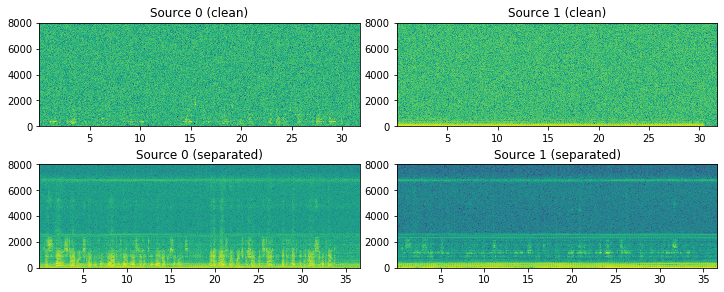

In [63]:
fig = plt.figure()
fig.set_size_inches(10,  4)

plt.subplot(2,2,1)
plt.specgram(ref[0,:,0], NFFT=1024, Fs=room.fs)
plt.title('Source 0 (clean)')

plt.subplot(2,2,2)
plt.specgram(ref[1,:,0], NFFT=1024, Fs=room.fs)
plt.title('Source 1 (clean)')

plt.subplot(2,2,3)
plt.specgram(y[perm[0],:], NFFT=1024, Fs=room.fs)
plt.title('Source 0 (separated)')

plt.subplot(2,2,4)
plt.specgram(y[perm[1],:], NFFT=1024, Fs=room.fs)
plt.title('Source 1 (separated)')

plt.tight_layout(pad=0.5)

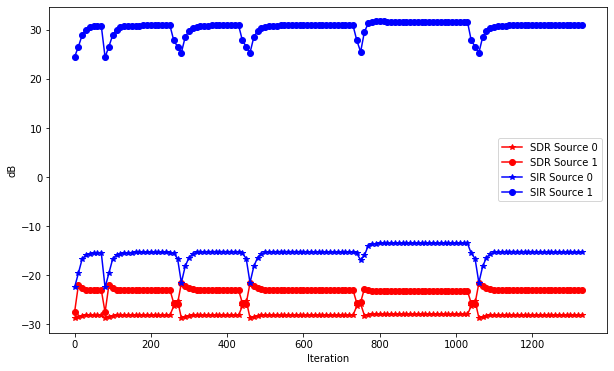

In [64]:
fig = plt.figure()
fig.set_size_inches(10, 6)
a = np.array(SDR)
b = np.array(SIR)
plt.plot(np.arange(a.shape[0]) * 10, a[:,0], label='SDR Source 0', c='r', marker='*')
plt.plot(np.arange(a.shape[0]) * 10, a[:,1], label='SDR Source 1', c='r', marker='o')
plt.plot(np.arange(b.shape[0]) * 10, b[:,0], label='SIR Source 0', c='b', marker='*')
plt.plot(np.arange(b.shape[0]) * 10, b[:,1], label='SIR Source 1', c='b', marker='o')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('dB')

plt.show()

In [68]:
print("Mixed signal:")
IPython.display.Audio(mics_signals[0], rate=fsM)

Mixed signal:


In [66]:
print("Separated source 0:")
IPython.display.Audio(y[0], rate=fs2)

Separated source 0:


In [69]:
print("Separated source 1:")
IPython.display.Audio(y[1], rate=fs2)

Separated source 1:
